Gabriel Marcelino,
Grant Burk

## Load Data and Install Dependencies

In [55]:
import librosa
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional, Input
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional, TimeDistributed
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, classification_report
import audiomentations as au

# Check current working directory and list files
print("Current working directory:", os.getcwd())
print("Files in the directory:", os.listdir())

# Load metadata
metadata_path = 'cv-corpus-20.0-delta-2024-12-06/en/validated.tsv'
print(f"Loading metadata from: {metadata_path}")
try:
    metadata = pd.read_csv(metadata_path, sep='\t')
    print("Metadata loaded successfully.")
except FileNotFoundError as e:
    print(f"Error: {e}")
    exit()

Current working directory: C:\Users\grant\PycharmProjects\speech-recognition
Files in the directory: ['.git', '.gitignore', '.idea', 'asr_model.h5', 'cv-corpus-20.0-delta-2024-12-06', 'Grant_TestSpeechRecognition.ipynb', 'Labs', 'model.keras', 'README.md', 'SpeechRecognition.ipynb']
Loading metadata from: cv-corpus-20.0-delta-2024-12-06/en/validated.tsv
Metadata loaded successfully.


## Pre Process Data

In [56]:

# Preprocess audio
def preprocess_audio(file_path, target_sr=16000):
    try:
        y, sr = librosa.load(file_path, sr=None)
        y_resampled = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
        print(f"Processed audio file: {file_path}, Duration: {len(y_resampled) / target_sr:.2f}s")
        return y_resampled, target_sr
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None, None

# Process all files
audio_data = []
for index, row in metadata.iterrows():
    file_path = os.path.join('cv-corpus-20.0-delta-2024-12-06/en/clips', row['path'])
    transcription = row['sentence']
    print(f"Processing file {index + 1}/{len(metadata)}: {file_path}")
    y, sr = preprocess_audio(file_path)
    if y is not None:
        audio_data.append({'audio': y, 'sampling_rate': sr, 'transcription': transcription})
    else:
        print(f"Skipping file: {file_path}")

# Summary
print(f"Processed {len(audio_data)} audio files successfully.")


Processing file 1/250: cv-corpus-20.0-delta-2024-12-06/en/clips\common_voice_en_41383256.mp3
Processed audio file: cv-corpus-20.0-delta-2024-12-06/en/clips\common_voice_en_41383256.mp3, Duration: 4.82s
Processing file 2/250: cv-corpus-20.0-delta-2024-12-06/en/clips\common_voice_en_41823983.mp3
Processed audio file: cv-corpus-20.0-delta-2024-12-06/en/clips\common_voice_en_41823983.mp3, Duration: 4.72s
Processing file 3/250: cv-corpus-20.0-delta-2024-12-06/en/clips\common_voice_en_41881685.mp3
Processed audio file: cv-corpus-20.0-delta-2024-12-06/en/clips\common_voice_en_41881685.mp3, Duration: 8.06s
Processing file 4/250: cv-corpus-20.0-delta-2024-12-06/en/clips\common_voice_en_41799514.mp3
Processed audio file: cv-corpus-20.0-delta-2024-12-06/en/clips\common_voice_en_41799514.mp3, Duration: 7.92s
Processing file 5/250: cv-corpus-20.0-delta-2024-12-06/en/clips\common_voice_en_41552032.mp3
Processed audio file: cv-corpus-20.0-delta-2024-12-06/en/clips\common_voice_en_41552032.mp3, Durati

## Experimenting with Data

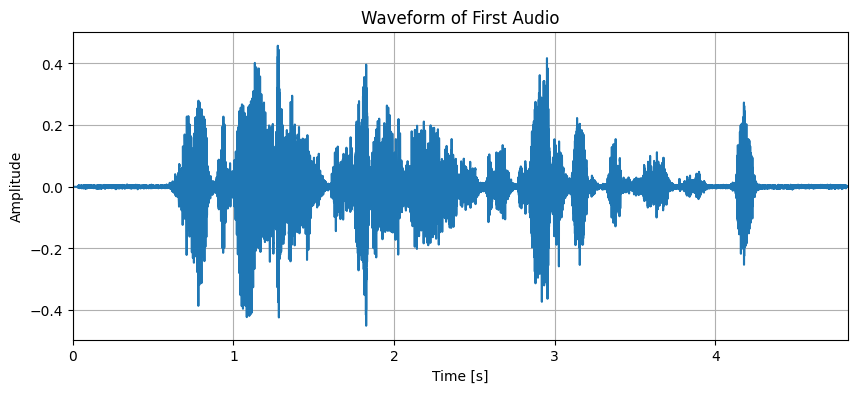

The outer rim has undergone some erosion due to subsequent impacts.


In [57]:
# plot waveform for first audio file
def plot_waveform(y, sr, title='Waveform'):
    plt.figure(figsize=(10, 4))
    plt.plot(np.linspace(0, len(y) / sr, num=len(y)), y)
    plt.title(title)
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    plt.xlim(0, len(y) / sr)
    plt.grid()
    plt.show()

plot_waveform(audio_data[0]['audio'], audio_data[0]['sampling_rate'], title='Waveform of First Audio')
print(audio_data[0]['transcription'])
# playable audio
ipd.Audio(audio_data[0]['audio'], rate=audio_data[0]['sampling_rate'])

## Feature Extraction & Tokenizing Trancriptions

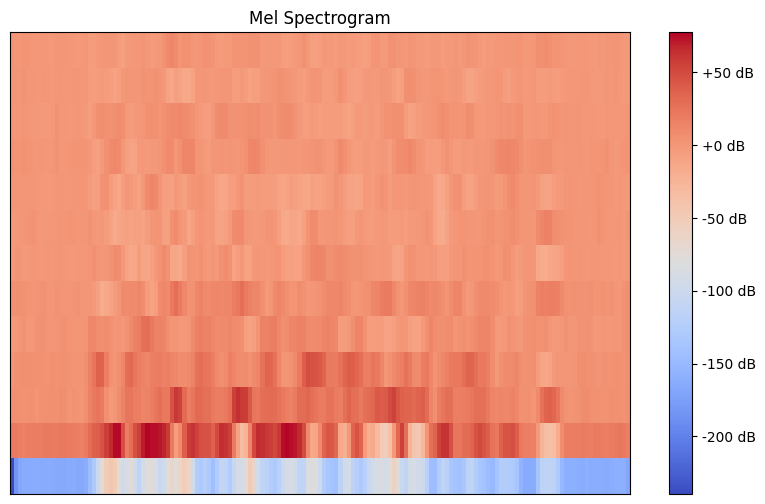

In [58]:
def extract_mfcc(audio, sr, n_mfcc=13, n_mels=23, fmin=0, fmax=8000, hop_length=512, win_length=2048):
    # Compute the Mel spectrogram
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels, fmin=fmin, fmax=fmax, hop_length=hop_length, win_length=win_length)
    # Convert Mel spectrogram to MFCC
    mfcc = librosa.feature.mfcc(S=librosa.power_to_db(mel_spec), n_mfcc=n_mfcc)
    
    return mfcc

# Example usage
all_mfcc = []
for audio in audio_data:
    mel_spec = extract_mfcc(audio['audio'], sr=16000)
    all_mfcc.append(mel_spec)

# Plot the Mel spectrogram using librosa's specshow
plt.figure(figsize=(10, 6))
librosa.display.specshow(all_mfcc[0])
plt.colorbar(format='%+2.0f dB')
plt.title("Mel Spectrogram")
plt.show()

# Tokenize the transcriptions (characters or words)
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts([audio['transcription'] for audio in audio_data])

# Add a new field 'tokenized_transcript' to each audio_data entry
for audio in audio_data:
    audio['tokenized_transcript'] = tokenizer.texts_to_sequences([audio['transcription']])[0]



## Split train - test

In [59]:
# Train-test split
X_train_base, X_test_base, y_train, y_test = train_test_split(
    all_mfcc,
    [audio['tokenized_transcript'] for audio in audio_data],
    test_size=0.2,
    random_state=42
)

## Padding Manipulation

In [60]:
# Maximum sequence length
min_len = 2048
resize_length = max(mfcc.shape[1] for mfcc in all_mfcc)


# Pad MFCC sequences with a max length of 'resize_length'
padded_X_train = [np.pad(mfcc, ((0, 0), (0, resize_length - mfcc.shape[1])), mode='constant') if mfcc.shape[1] < resize_length else mfcc[:, :resize_length] for mfcc in X_train_base]
padded_X_test = [np.pad(mfcc, ((0, 0), (0, resize_length - mfcc.shape[1])), mode='constant') if mfcc.shape[1] < resize_length else mfcc[:, :resize_length] for mfcc in X_test_base]

# Transpose to match model input shape (batch, time_steps, features)
X_train = np.transpose(np.array(padded_X_train), (0, 2, 1))
X_test = np.transpose(np.array(padded_X_test), (0, 2, 1))

# Pad target sequences
y_train = pad_sequences(y_train, maxlen=resize_length, padding='post')
y_test = pad_sequences(y_test, maxlen=resize_length, padding='post')


## Build Model

In [61]:
# Update model architecture
model = Sequential([
    Input(shape=(resize_length, 13)),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.2),
    TimeDistributed(Dense(len(tokenizer.word_index) + 1, activation='softmax'))
])

# Compile the model
model.compile(
    optimizer='adam', 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

# Train the model with early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=3, 
    restore_best_weights=True
)


## Train the Model

Train on original dataset

In [62]:
# Train on base data
model.fit(
    X_train, y_train, 
    epochs=10, 
    batch_size=32, 
    validation_split=0.2,
    callbacks=[early_stopping]
)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.4424 - loss: 3.7274 - val_accuracy: 0.7168 - val_loss: 3.1157
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 580ms/step - accuracy: 0.7503 - loss: 2.9074 - val_accuracy: 0.8266 - val_loss: 1.2573
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 601ms/step - accuracy: 0.8381 - loss: 1.0584 - val_accuracy: 0.8266 - val_loss: 0.8784
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 598ms/step - accuracy: 0.8389 - loss: 0.8284 - val_accuracy: 0.8266 - val_loss: 0.8599
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 597ms/step - accuracy: 0.8387 - loss: 0.8007 - val_accuracy: 0.8266 - val_loss: 0.8124
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 622ms/step - accuracy: 0.8394 - loss: 0.7462 - val_accuracy: 0.8266 - val_loss: 0.7700
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 635ms/step - accuracy: 0.8408 - loss: 0.7120 - val_accuracy: 0.8266 - val_loss: 0.7483
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 628ms/step - accuracy: 0.8423 - loss: 0.6858 - val_accuracy: 0.8266 - val_loss: 0

Train and augment training set repeatedly

In [63]:
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift

# Define the augmentation pipeline
augmenter = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.005),
    TimeStretch(min_rate=0.8, max_rate=1.25),
    PitchShift(min_semitones=-2, max_semitones=2)
])

# Define a function for augmenting MFCCs during training
def augment_mfccs(X):
    augmented_X = []
    for mfcc in X:
        # Apply augmentation to each MFCC in the batch
        augmented_mfcc = augmenter(mfcc, sample_rate=16000)  # Apply augmentation
        augmented_X.append(augmented_mfcc)
    return np.array(augmented_X)

# You can also augment the data on-the-fly during each epoch:
for epoch in range(10):
    
    # Pad MFCC sequences
    padded_X_train = [np.pad(mfcc, ((0, 0), (0, max(min_len, mfcc.shape[1]) - mfcc.shape[1])), mode='constant') for mfcc in X_train_base]
    
    # Augment the training data on the fly
    augmented_X_train = augment_mfccs(padded_X_train)

    padded_X_train = [np.pad(mfcc, ((0, 0), (0, max(min_len, mfcc.shape[1]) - mfcc.shape[1])), mode='constant') for mfcc in
                      X_train_base]
    
    resize_X_train = [np.pad(mfcc, ((0, 0), (0, max(0, resize_length - mfcc.shape[1]))), mode='constant')[:resize_length, :]
                      for mfcc in X_train_base]
    
    # Transpose to match model input shape (batch, time_steps, features)
    X_train = np.transpose(np.array(resize_X_train), (0, 2, 1))
    
# Train on the augmented data
    model.fit(
        X_train, y_train,
        epochs=10,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping]
    )

# Save the model
model.save('model.keras')

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 653ms/step - accuracy: 0.8417 - loss: 0.6383 - val_accuracy: 0.8273 - val_loss: 0.6904
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 661ms/step - accuracy: 0.8394 - loss: 0.6426 - val_accuracy: 0.8297 - val_loss: 0.6801
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 675ms/step - accuracy: 0.8440 - loss: 0.6231 - val_accuracy: 0.8338 - val_loss: 0.6725
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 698ms/step - accuracy: 0.8454 - loss: 0.6196 - val_accuracy: 0.8332 - val_loss: 0.6633
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 668ms/step - accuracy: 0.8466 - loss: 0.6091 - val_accuracy: 0.8341 - val_loss: 0.6581
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 657ms/step - accuracy: 0.8530 - loss: 0.5775 - val_accuracy: 0.8357 - val_loss: 0.6519
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 666ms/step - accuracy: 0.8484 - loss: 0.5889 - val_accuracy: 0.8362 - val_loss: 0.6454
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 674ms/step - accuracy: 0.8528 - loss: 0.5718 - val_accuracy: 0.8367 - val_loss:

## Testing

Testing against the training data

In [65]:
from sklearn.metrics import classification_report

# After training, evaluate on test set
y_pred = model.predict(X_train)
y_pred_classes = np.argmax(y_pred, axis=-1)

# Flatten predictions and true labels
y_true_flat = y_train.flatten()
y_pred_flat = y_pred_classes.flatten()

# Generate classification report excluding padding, handle zero division cases
print(classification_report(
    y_true_flat[y_true_flat != 0],
    y_pred_flat[y_true_flat != 0],
    zero_division=1
))

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step
              precision    recall  f1-score   support

           0       0.00      1.00      0.00         0
           1       0.16      0.71      0.26      1782
           2       0.15      0.07      0.10      1263
           3       0.24      0.02      0.03       883
           4       0.12      0.01      0.02       868
           5       0.20      0.03      0.05       748
           6       0.21      0.01      0.02       739
           7       0.25      0.02      0.03       736
           8       0.15      0.00      0.01       714
           9       0.17      0.01      0.01       693
          10       0.00      0.00      0.00       464
          11       1.00      0.00      0.00       475
          12       0.67      0.01      0.01       394
          13       1.00      0.00      0.00       310
          14       1.00      0.00      0.00       261
          15       1.00      0.00      0.00       262
          16       1.00      0.00      0.0

Testing against the test data

In [66]:
from sklearn.metrics import classification_report

## DEBUGGING

# After training, evaluate on test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=-1)

# Flatten predictions and true labels
y_true_flat = y_test.flatten()
y_pred_flat = y_pred_classes.flatten()

# Generate classification report excluding padding, handle zero division cases
print(classification_report(
    y_true_flat[y_true_flat != 0],
    y_pred_flat[y_true_flat != 0],
    zero_division=1
))


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
              precision    recall  f1-score   support

           0       0.00      1.00      0.00         0
           1       0.16      0.60      0.25       459
           2       0.08      0.05      0.06       309
           3       0.00      0.00      0.00       215
           4       0.12      0.04      0.05       227
           5       0.00      0.00      0.00       202
           6       0.00      0.00      0.00       179
           7       0.00      0.00      0.00       180
           8       0.00      0.00      0.00       176
           9       0.00      0.00      0.00       160
          10       1.00      0.00      0.00       128
          11       1.00      0.00      0.00       111
          12       1.00      0.00      0.00       100
          13       1.00      0.00      0.00        63
          14       1.00      0.00      0.00        69
          15       1.00      0.00      0.00        66
          16       1.00      0.00      0.00

## Evaluation

In [67]:
prediction = model.predict(X_test[:1])
print(prediction.shape)
print("Model input shape:", model.input_shape)
print("Model output shape:", model.output_shape)

print("X_test shape:", X_test.shape)
print("X_test[:1]:", X_test[:1])

print("Prediction shape:", prediction.shape)

# Get predicted sequence and filter out padding (0) tokens
predicted_sequence = np.argmax(prediction, axis=-1)[0]  # Get the most likely token for each timestep

# Filter out padding tokens (0) and optionally low-probability tokens
predicted_sequence = [token for idx, token in enumerate(predicted_sequence) if token != 0]

# Decode the filtered sequence
decoded_text = tokenizer.sequences_to_texts([predicted_sequence])[0] if predicted_sequence else "No valid tokens."
print("Decoded Prediction:", decoded_text)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
(1, 375, 37)
Model input shape: (None, 375, 13)
Model output shape: (None, 375, 37)
X_test shape: (50, 375, 13)
X_test[:1]: [[[-2.5105228e+02  3.8867485e+01  5.4247475e+00 ...  4.1707468e+00
   -3.7050252e+00  2.8336549e-01]
  [-2.0614487e+02  5.2747047e+01 -1.4357971e+00 ...  1.6314963e+00
   -4.2914362e+00 -1.9523144e-02]
  [-2.0852606e+02  5.0606026e+01  9.0310144e-01 ... -1.2369895e+00
   -2.4960389e+00 -1.2397758e+00]
  ...
  [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
    0.0000000e+00  0.0000000e+00]
  [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
    0.0000000e+00  0.0000000e+00]
  [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
    0.0000000e+00  0.0000000e+00]]]
Prediction shape: (1, 375, 37)
Decoded Prediction:                                                                                            


## Results
### Hyperparameters (Initial Setup)  
- LSTM Units: 128 (Bidirectional).
- Dropout: 0.2.
- Dense Units: Size of the tokenizer vocabulary + 1.
- Optimizer: Adam.
- Loss: Sparse categorical crossentropy.
- Batch Size: 32.
- Epochs: 10.
### Analysis: With these parameters, I am getting high accuracy somehow, but the predicted output is empty and doesn't match the transcription. This could be due to an issue with the output layer or how the predicted token sequences are being decoded. It’s possible that the model is producing tokens with very low probability for each timestep, leading to incorrect or empty predictions. Additionally, misalignment between the input MFCC features and tokenized output could be contributing to poor decoding. 
### Tuning: To address this, we'll try adjusting the LSTM units, dropout rate, and batch size for better learning, and ensure that the token decoding process is correct. 
### Hyperparameters (Second Try)  


## Test with Pre-Trained Model

In [68]:
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
import torch

# Load pre-trained model
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")

# Process the audio array directly
audio_input = audio_data[0]['audio']
input_values = processor(audio_input, return_tensors="pt", sampling_rate=16000).input_values

# Perform inference
with torch.no_grad():
    logits = model(input_values).logits
    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = processor.batch_decode(predicted_ids)[0]
    print("Transcription:", transcription)
    print("Original:", audio_data[0]['transcription'])
    print("Are they equal (case insensitive)?", transcription.lower() == audio_data[0]['transcription'].lower())



Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Transcription: THE AUTAR ROOM HAS UNDERGONE SUMMY ROSION DUE TO SUBSEQUENT INTACTS
Original: The outer rim has undergone some erosion due to subsequent impacts.
Are they equal (case insensitive)? False


## References
https://devopedia.org/audio-feature-extraction

https://www.geeksforgeeks.org/introduction-to-recurrent-neural-network/